## Inicialización

## Cargar datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/`
- La carpeta `final_files` con 7600 fotos
- El archivo `labels.csv` con leyendas, con dos columnas: `file_name` y `real_age`

Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [11]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

## EDA

Primeras filas del archivo CSV:
    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17

Valores nulos por columna:
file_name    0
real_age     0
dtype: int64

Estadísticas descriptivas de la edad:
count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


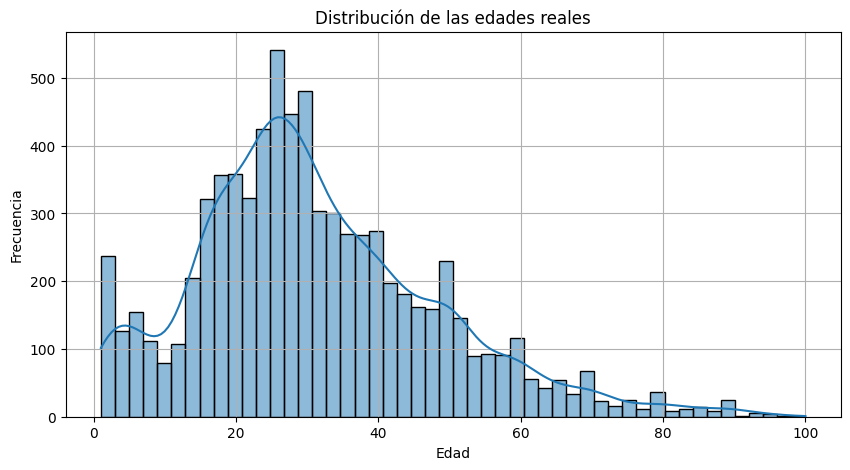


Número de imágenes faltantes: 0


In [12]:
# Cargar los datos
labels = pd.read_csv('/Users/dvillanueva/Data_science/Tripleten/Sprint16/datasets/faces/labels.csv')

# Mostrar las primeras filas
print("Primeras filas del archivo CSV:")
print(labels.head())

# Comprobación de valores nulos
print("\nValores nulos por columna:")
print(labels.isnull().sum())

# Estadísticas descriptivas de la edad
print("\nEstadísticas descriptivas de la edad:")
print(labels['real_age'].describe())

# Histograma de las edades
plt.figure(figsize=(10, 5))
sns.histplot(labels['real_age'], bins=50, kde=True)
plt.title("Distribución de las edades reales")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

# Verificar si todas las imágenes están presentes
image_dir = '/Users/dvillanueva/Data_science/Tripleten/Sprint16/datasets/faces/final_files'
missing_images = [f for f in labels['file_name'] if not os.path.exists(os.path.join(image_dir, f))]

print(f"\nNúmero de imágenes faltantes: {len(missing_images)}")
if missing_images:
    print("Ejemplos de imágenes faltantes:", missing_images[:5])

### Conclusiones

* Distribución sesgada hacia jovenes.

La mayoría de las edades se concentran entre los 20 y 40 años, con un pico en los 20s y un declive progresivo hacia los 60 o más.

* Presencia de valores atípicos

Existen edades tan bajas como 1 año y tan altas como 100 años, aunque estas podrían ser reales, conviene monitorearlas como posibles outliers

3. Amplio rango de edades

El dataset incluye tanto a niños como a adultos mayores, lo cual es últil para construir un modelo generalizable, pero puede ser un reto para el entranamiento si las clases extremas están poco representadas.

4. Datos completos

No hay valores nulos, lo cual es excelente porque asi no se requeire una limpieza previa



## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crear un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [14]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_gen_flow

In [15]:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_gen_flow

In [16]:
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    # Esta linea estaba antes, la quitamos por for layer... backbone.trainable = False

    for layer in backbone.layers[-30:]:
        layer.trainable = True

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3)) # Antes no estaba esta linea, veamos como se comporta el modelo sino quitarla
    model.add(Dense(1))   # Se quito esta activation='relu'))

    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

    return model

In [17]:
def train_model(model, train_data, test_data, batch_size=16, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    

    lr_callback = ReduceLROnPlateau(
        monitor='val_loss',     # Métrica a observar
        factor=0.5,             # Factor de reducción del learning rate
        patience=2,             # Número de épocas sin mejora para activar
        verbose=1,              # Muestra mensaje en consola
        min_lr=1e-6             # Límite inferior para el learning rate
    )
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        callbacks=[lr_callback]
    )
    return model

In [ ]:
input_shape = (224, 224, 3)
path = '/Users/dvillanueva/Data_science/Tripleten/Sprint16/datasets/faces/'

train_data = load_train(path)
test_data = load_test(path)

model = create_model(input_shape)
model = train_model(model, train_data, test_data, batch_size=16, epochs=15)

Found 6073 validated image filenames.
Found 1518 validated image filenames.
Epoch 1/10
760/760 - 1381s - loss: 484.5066 - mae: 16.6798 - val_loss: 290.8588 - val_mae: 13.5973 - 1381s/epoch - 2s/step
Epoch 2/10
760/760 - 1381s - loss: 294.7101 - mae: 13.3081 - val_loss: 291.9505 - val_mae: 13.6642 - 1381s/epoch - 2s/step
Epoch 3/10
760/760 - 1383s - loss: 294.4767 - mae: 13.3146 - val_loss: 286.2899 - val_mae: 13.2648 - 1383s/epoch - 2s/step
Epoch 4/10


### Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [ ]:
import inspect

init_str = """
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
"""

with open('run_model_on_gpu.py', 'w') as f:
    f.write(init_str)
    f.write('\\n\\n')
    
    for fn_name in [load_train, load_test, create_model, train_model]:
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\\n\\n')

### Resultado

Coloca aquí el resultado de la plataforma GPU como una celda Markdown.

Found 6073 validated image filenames.
Found 1518 validated image filenames.
Epoch 1/15
/Users/dvillanueva/miniforge3/envs/tf_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
380/380 - 609s - 2s/step - loss: 229.7287 - mae: 11.5580 - val_loss: 296.9078 - val_mae: 13.0021 - learning_rate: 5.0000e-04
Epoch 2/15
380/380 - 680s - 2s/step - loss: 154.2141 - mae: 9.5160 - val_loss: 259.6823 - val_mae: 12.3016 - learning_rate: 5.0000e-04
Epoch 3/15
380/380 - 642s - 2s/step - loss: 117.1665 - mae: 8.3344 - val_loss: 154.4868 - val_mae: 9.2376 - learning_rate: 5.0000e-04
Epoch 4/15
380/380 - 591s - 2s/step - loss: 99.5107 - mae: 7.6186 - val_loss: 200.4187 - val_mae: 10.5000 - learning_rate: 5.0000e-04
Epoch 5/15
380/380 - 744s - 2s/step - loss: 76.8302 - mae: 6.7618 - val_loss: 112.7845 - val_mae: 7.9029 - learning_rate: 5.0000e-04
Epoch 6/15
380/380 - 738s - 2s/step - loss: 64.7913 - mae: 6.1603 - val_loss: 153.2996 - val_mae: 9.7522 - learning_rate: 5.0000e-04
Epoch 7/15

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
380/380 - 836s - 2s/step - loss: 52.8805 - mae: 5.5569 - val_loss: 120.6397 - val_mae: 8.5589 - learning_rate: 5.0000e-04
Epoch 8/15
380/380 - 835s - 2s/step - loss: 36.4579 - mae: 4.6219 - val_loss: 83.1545 - val_mae: 6.8520 - learning_rate: 2.5000e-04
Epoch 9/15
380/380 - 890s - 2s/step - loss: 25.2125 - mae: 3.8111 - val_loss: 89.9598 - val_mae: 7.3280 - learning_rate: 2.5000e-04
Epoch 10/15

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
380/380 - 694s - 2s/step - loss: 22.6954 - mae: 3.6109 - val_loss: 83.7857 - val_mae: 6.9127 - learning_rate: 2.5000e-04
Epoch 11/15
380/380 - 724s - 2s/step - loss: 20.3504 - mae: 3.3299 - val_loss: 80.7398 - val_mae: 6.8801 - learning_rate: 1.2500e-04
Epoch 12/15
380/380 - 714s - 2s/step - loss: 16.4028 - mae: 3.0348 - val_loss: 78.4412 - val_mae: 6.7456 - learning_rate: 1.2500e-04
Epoch 13/15
380/380 - 756s - 2s/step - loss: 15.4467 - mae: 2.9428 - val_loss: 83.4867 - val_mae: 7.0758 - learning_rate: 1.2500e-04
Epoch 14/15

Epoch 14: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
380/380 - 657s - 2s/step - loss: 15.9571 - mae: 2.9244 - val_loss: 78.8393 - val_mae: 6.7482 - learning_rate: 1.2500e-04
Epoch 15/15
380/380 - 741s - 2s/step - loss: 15.6974 - mae: 2.9352 - val_loss: 78.9884 - val_mae: 6.8108 - learning_rate: 6.2500e-05

## Conclusiones

Obtuvimos un resultado de MAE(error absoluto medio) de 6.74, es decir, si una persona tiene 21 años, el modelo predecirá que tiene entre 14 y 28 años.

Es un buen resultado, porque para el objetivo del proyecto (no vender alcohol a menores), este modelo permite definir un umbral conservador. Por ejemplo, si el modelo predice una edad menor a 27 años, la tienda podría denegar la venta a la persona para reducir los posibles riesgos legales

También la diferencia entre los errores de entrenamiento y validación es baja( aprox 3.8 años), lo que sugiere una buena generalización y bajo sobreajuste.

El modelo final es funcional, generaliza bien y puede utilizarse en un sistema real.

# Lista de revisión

- [x]  El Notebook estaba abierto 
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución
- [x]  Se realizó el análisis exploratorio de datos
- [x]  Los resultados del análisis exploratorio de datos se presentan en el notebook final
- [x]  El valor EAM del modelo no es superior a 8
- [x]  El código de entrenamiento del modelo se copió en el notebook final
- [x]  El resultado de entrenamiento del modelo se copió en el notebook final
- [x]  Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo